In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install spectral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 3.4 MB/s eta 0:00:00


In [3]:
pip install pillow

In [4]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.8 MB/s eta 0:00:00


In [5]:
import spectral

In [6]:
import os

In [7]:
pip install scikit-image


In [ ]:
import os
from skimage.io import imread

# Define the dataset path
dataset_path = "/content/drive/MyDrive/dataset/okra/okraimages"

# Define the class directories
class_dirs = {
    'low_concentration': os.path.join(dataset_path, 'low_concentration'),
    'medium_concentration': os.path.join(dataset_path, 'medium_concentration'),
    'high_concentration': os.path.join(dataset_path, 'high_concentration'),
    'pure': os.path.join(dataset_path, 'pure')
}

# Initialize the image and label lists
image_data_list = []
label_list = []

# Loop through each class directory and load images
for label, class_dir in class_dirs.items():
    for file_name in os.listdir(class_dir):
        if file_name.endswith(".tiff") or file_name.endswith(".tif"):  # Ensure it's a .tiff file
            image_path = os.path.join(class_dir, file_name)
            image = imread(image_path)
            image_data_list.append(image)
            label_list.append(label)

# Debug: Check if images and labels were loaded
print(f"Loaded {len(image_data_list)} images.")
print(f"Loaded {len(label_list)} labels.")

Loaded 615 images.
Loaded 615 labels.


In [ ]:
import os
import numpy as np
from skimage import io
from skimage.transform import rotate, resize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Define the path to your images directory
images_path = "/content/drive/MyDrive/dataset/okra/okraimages"  # Update this to your images directory
target_shape = (100, 100, 10)  # Specify the target shape for all images (e.g., 100x100 with 10 bands)

# Load images and labels from subfolders
def load_data(images_path, target_shape):
    image_data_list = []
    label_list = []

    # Define class mappings based on folder names
    class_map = {'pure': 0, 'medium_concentration': 1, 'low_concentration': 2, 'high_concentration': 3}

    for class_name, class_id in class_map.items():
        class_folder = os.path.join(images_path, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith('.tiff'):
                    img_path = os.path.join(class_folder, filename)
                    image = io.imread(img_path)

                    # Resize the image to the target shape
                    resized_image = resize(image, target_shape, anti_aliasing=True)
                    image_data_list.append(resized_image)
                    label_list.append(class_id)  # Append the numeric label based on folder name

    return image_data_list, label_list

# Augment image function
def augment_image(image, target_shape, rotation_range=30, flip=True, add_noise=False, zoom_range=(0.8, 1.2)):
    h, w, b = image.shape
    augmented_image = np.empty_like(image)

    # Rotation
    angle = np.random.uniform(-rotation_range, rotation_range)
    for band in range(b):
        rotated_image = rotate(image[:, :, band], angle, resize=True)
        if rotated_image.shape[:2] != (h, w):
            rotated_image = resize(rotated_image, (h, w), anti_aliasing=True)
        augmented_image[:, :, band] = np.clip(rotated_image, 0, 255)

    # Flipping
    if flip and np.random.rand() > 0.5:
        augmented_image = np.flip(augmented_image, axis=1)

    # Adding noise
    if add_noise:
        noise = np.random.normal(0, 25, augmented_image.shape)
        augmented_image = np.clip(augmented_image + noise, 0, 255)

    # Zoom
    if zoom_range is not None:
        zoom_factor = np.random.uniform(zoom_range[0], zoom_range[1])
        new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
        for band in range(b):
            zoomed_image = resize(augmented_image[:, :, band], (new_h, new_w), anti_aliasing=True)
            if zoomed_image.shape[:2] != (h, w):
                zoomed_image = resize(zoomed_image, (h, w), anti_aliasing=True)
            augmented_image[:, :, band] = np.clip(zoomed_image, 0, 255)

    # Ensure the augmented image has the target shape
    return resize(augmented_image, target_shape, anti_aliasing=True)

# Load and preprocess the data
image_data_list, label_list = load_data(images_path, target_shape)
print(f"Length of image_data_list: {len(image_data_list)}")
print(f"Length of label_list: {len(label_list)}")

# Apply augmentation to the dataset
augmented_image_list = []
augmented_label_list = []

for img, label in zip(image_data_list, label_list):
    # Original image
    augmented_image_list.append(img)
    augmented_label_list.append(label)

    # Create multiple augmented copies (say, 3 augmented versions for each image)
    for _ in range(3):
        augmented_image = augment_image(img, target_shape)
        augmented_image_list.append(augmented_image)
        augmented_label_list.append(label)

# Convert lists to numpy arrays
X_augmented = np.array(augmented_image_list)
y_augmented = np.array(augmented_label_list)

# Debug: Check if X_augmented and y_augmented have the correct lengths
print(f"X_augmented shape: {X_augmented.shape}")
print(f"y_augmented length: {len(y_augmented)}")

# One-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_augmented_onehot = one_hot_encoder.fit_transform(y_augmented.reshape(-1, 1))

# Debugging: Check the shape of the one-hot encoded labels
print(f"y_augmented_onehot shape: {y_augmented_onehot.shape}")
print(f"First 5 entries of y_augmented_onehot: {y_augmented_onehot[:5]}")

# Further steps: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented_onehot, test_size=0.2, random_state=42)

# Model creation and training goes here...




Length of image_data_list: 615
Length of label_list: 615
X_augmented shape: (2460, 100, 100, 10)
y_augmented length: 2460
y_augmented_onehot shape: (2460, 4)
First 5 entries of y_augmented_onehot: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Loaded 100 images from medium_concentration
Loaded 220 images from high_concentration
Loaded 395 images from pure
Loaded 615 images from low_concentration
X_train shape: (492, 4096, 3)
y_train shape: (492, 4)
X_test shape: (123, 4096, 3)
y_test shape: (123, 4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4094, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2047, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 2045, 64)            │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1022, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 1020, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 510, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65280)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,355,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,387,716 (32.00 MB)

 Trainable params: 8,387,716 (32.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 414ms/step - accuracy: 0.3531 - loss: 1.3733 - val_accuracy: 0.3089 - val_loss: 1.3606
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 401ms/step - accuracy: 0.3645 - loss: 1.3501 - val_accuracy: 0.3089 - val_loss: 1.3640
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 620ms/step - accuracy: 0.3668 - loss: 1.3239 - val_accuracy: 0.3089 - val_loss: 1.3493
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 396ms/step - accuracy: 0.3540 - loss: 1.3266 - val_accuracy: 0.3089 - val_loss: 1.3110
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 520ms/step - accuracy: 0.3649 - loss: 1.2372 - val_accuracy: 0.3577 - val_loss: 1.1500
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - accuracy: 0.4886 - loss: 1.0308 - val_accuracy: 0.4390 - val_loss: 0.9553
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 549ms/step - accuracy: 0.5092 - loss: 0.9422 - val_accuracy: 0.4959 - val_loss: 0.9844
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step - accuracy: 0.5454 - loss: 0.8845 - val_accuracy

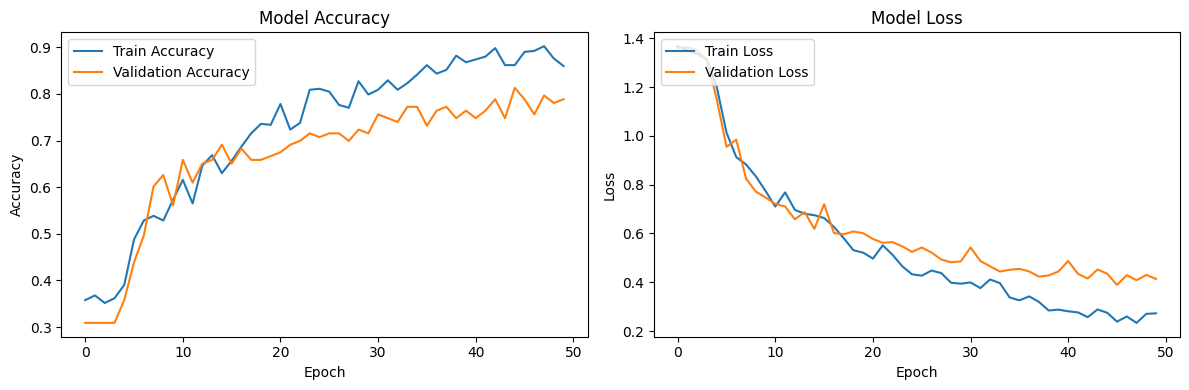

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Classification Report:
                      precision    recall  f1-score   support

                pure       0.84      0.84      0.84        38
medium_concentration       0.75      0.55      0.63        22
   low_concentration       0.84      0.84      0.84        38
  high_concentration       0.68      0.84      0.75        25

            accuracy                           0.79       123
           macro avg       0.78      0.77      0.77       123
        weighted avg       0.79      0.79      0.79       123



In [8]:
import os
import numpy as np
from skimage import io
from skimage.transform import resize  # Ensure resize is imported
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Class map based on subdirectory names
class_map = {
    'pure': 0,
    'medium_concentration': 1,
    'low_concentration': 2,
    'high_concentration': 3
}

# Function to load images and assign labels based on folder names
def load_images_from_subdirectories(main_directory, target_size=(64, 64)):
    image_data_list = []
    label_list = []

    for subdir in os.listdir(main_directory):
        subdir_path = os.path.join(main_directory, subdir)

        if os.path.isdir(subdir_path) and subdir in class_map:
            for filename in os.listdir(subdir_path):
                if filename.lower().endswith('.tiff'):  # Ensure case insensitivity
                    img_path = os.path.join(subdir_path, filename)
                    image = io.imread(img_path)
                    image_resized = resize(image, target_size, anti_aliasing=True)
                    image_data_list.append(image_resized)
                    label_list.append(class_map[subdir])

            # Debug: Print number of images loaded from the current subdirectory
            print(f"Loaded {len(label_list)} images from {subdir}")

    if len(image_data_list) == 0 or len(label_list) == 0:
        raise ValueError("No images or labels found. Please check the directory structure and filenames.")

    return np.array(image_data_list), np.array(label_list)

# Preprocessing
images_directory = "/content/drive/MyDrive/dataset/okra/okraimages"  # Update with your directory containing images
X_data, y_data = load_images_from_subdirectories(images_directory)

# Since we're working with 1D data, let's reshape the data accordingly.
# Convert 2D image data to 1D (assuming we're processing each pixel as a sequence).
X_data = X_data.reshape(X_data.shape[0], -1, 3)  # Flatten the 64x64 image into 1D (64*64=4096) per color channel.

# Normalize the images
X_data = X_data / 255.0

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_data_onehot = one_hot_encoder.fit_transform(y_data.reshape(-1, 1))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_onehot, test_size=0.2, random_state=42)

# Debug: Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Building the 1D CNN model
model = models.Sequential()

# Convolutional layers for 1D
model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 3)))
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))

# Flatten the output before feeding into the dense layers
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(4, activation='softmax'))  # 4 classes

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Get the predicted labels from the model
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report (precision, recall, f1-score)
class_labels = list(class_map.keys())
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

# Print the classification report
print("Classification Report:")
print(report)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Classification Report:
                      precision    recall  f1-score   support

                pure       0.91      0.82      0.86        38
medium_concentration       0.80      0.55      0.65        22
   low_concentration       0.83      0.92      0.88        38
  high_concentration       0.69      0.88      0.77        25

            accuracy                           0.81       123
           macro avg       0.81      0.79      0.79       123
        weighted avg       0.82      0.81      0.81       123

Confusion Matrix:
[[31  0  7  0]
 [ 0 12  0 10]
 [ 3  0 35  0]
 [ 0  3  0 22]]


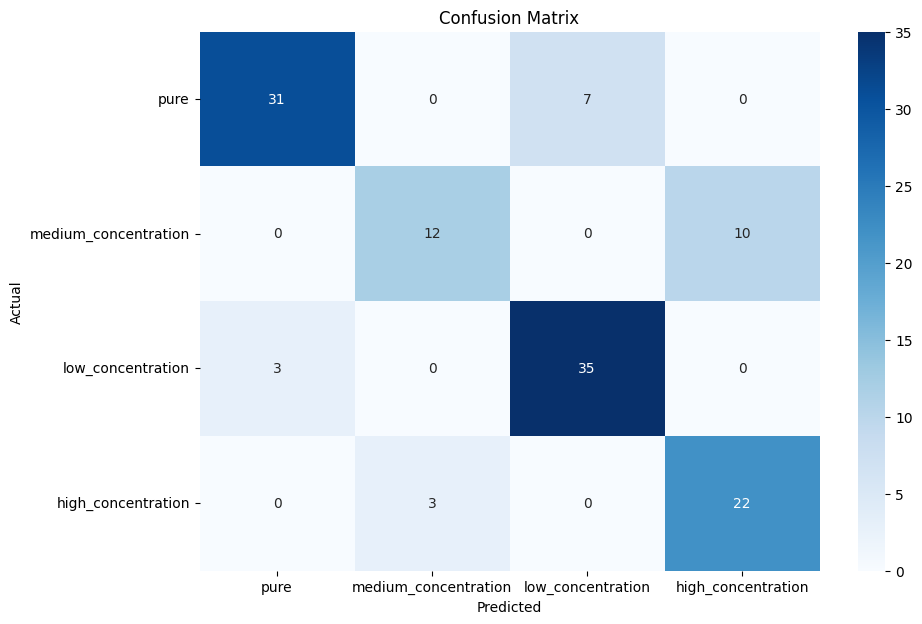

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming you have your model defined and trained, and X_test and y_test ready

# Get the predicted labels from the model
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report (precision, recall, f1-score)
class_labels = list(class_map.keys())
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

# Print the classification report
print("Classification Report:")
print(report)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Visualizing the confusion matrix using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

X_train shape: (492, 64, 64, 3)
y_train shape: (492, 4)
X_test shape: (123, 64, 64, 3)
y_test shape: (123, 4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,716 (2.61 MB)

 Trainable params: 683,716 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - accuracy: 0.2996 - loss: 1.3729 - val_accuracy: 0.3089 - val_loss: 1.3633
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.3656 - loss: 1.3357 - val_accuracy: 0.3089 - val_loss: 1.3674
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.3863 - loss: 1.3228 - val_accuracy: 0.3089 - val_loss: 1.3618
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.3359 - loss: 1.3583 - val_accuracy: 0.3089 - val_loss: 1.3793
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.3870 - loss: 1.3547 - val_accuracy: 0.3089 - val_loss: 1.3572
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.3791 - loss: 1.3345 - val_accuracy: 0.3089 - val_loss: 1.3569
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.3719 - loss: 1.3029 - val_accuracy: 0.3089 - val_loss: 1.2972
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.3756 - loss: 1.2120 - val_accuracy: 0.

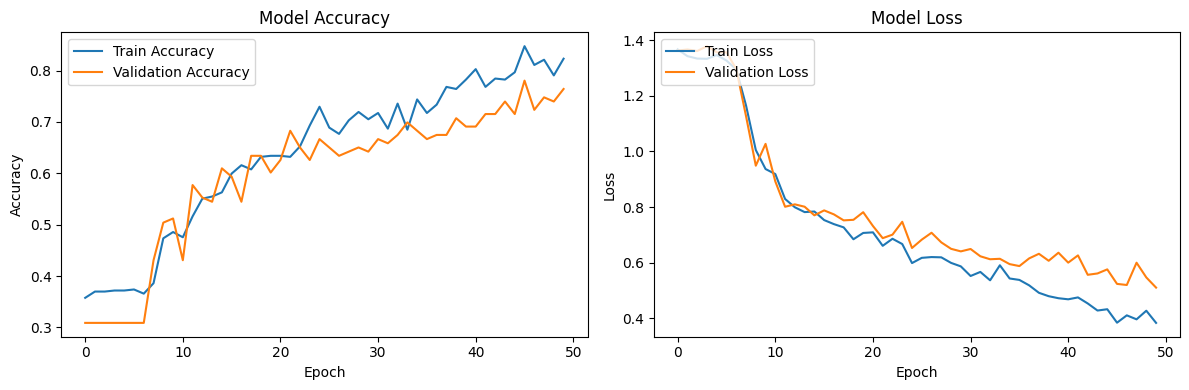

In [ ]:
import os
import numpy as np
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Class map based on subdirectory names
class_map = {
    'pure': 0,
    'medium_concentration': 1,
    'low_concentration': 2,
    'high_concentration': 3
}

# Function to load images and assign labels based on folder names
def load_images_from_subdirectories(main_directory, target_size=(64, 64)):
    image_data_list = []
    label_list = []

    for subdir in os.listdir(main_directory):
        subdir_path = os.path.join(main_directory, subdir)

        if os.path.isdir(subdir_path) and subdir in class_map:
            for filename in os.listdir(subdir_path):
                if filename.endswith('.tiff'):
                    img_path = os.path.join(subdir_path, filename)
                    image = io.imread(img_path)
                    image_resized = resize(image, target_size, anti_aliasing=True)
                    image_data_list.append(image_resized)
                    label_list.append(class_map[subdir])

    if len(image_data_list) == 0 or len(label_list) == 0:
        raise ValueError("No images or labels found. Please check the directory structure and filenames.")

    return np.array(image_data_list), np.array(label_list)

# Preprocessing
images_directory = "/content/drive/MyDrive/dataset/okra/okraimages"
X_data, y_data = load_images_from_subdirectories(images_directory)

# Normalize the images
X_data = X_data / 255.0

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_data_onehot = one_hot_encoder.fit_transform(y_data.reshape(-1, 1))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_onehot, test_size=0.2, random_state=42)

# Debug: Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Building the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before feeding into the dense layers
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(4, activation='softmax'))  # 4 classes

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

X_train shape: (492, 128, 64, 3)
y_train shape: (492, 4)
X_test shape: (123, 128, 64, 3)
y_test shape: (123, 4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_2 (Conv3D)                    │ (None, 126, 62, 1, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 63, 31, 1, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 61, 29, 1, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 30, 14, 1, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_4 (Conv3D)                    │ (None, 28, 12, 1, 128)      │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 14, 6, 1, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10752)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,376,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,470,148 (5.61 MB)

 Trainable params: 1,470,148 (5.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2886 - loss: 1.3767 - val_accuracy: 0.3089 - val_loss: 1.3738
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.3345 - loss: 1.3656 - val_accuracy: 0.3089 - val_loss: 1.3610
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3704 - loss: 1.3474 - val_accuracy: 0.3089 - val_loss: 1.3630
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.3704 - loss: 1.3288 - val_accuracy: 0.3089 - val_loss: 1.3599
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3600 - loss: 1.3450 - val_accuracy: 0.3089 - val_loss: 1.3634
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3960 - loss: 1.3074 - val_accuracy: 0.3089 - val_loss: 1.3602
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3427 - loss: 1.3629 - val_accuracy: 0.3089 - val_loss: 1.3642
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3870 - loss: 1.3273 - val_accuracy: 0.3089 - val_loss:

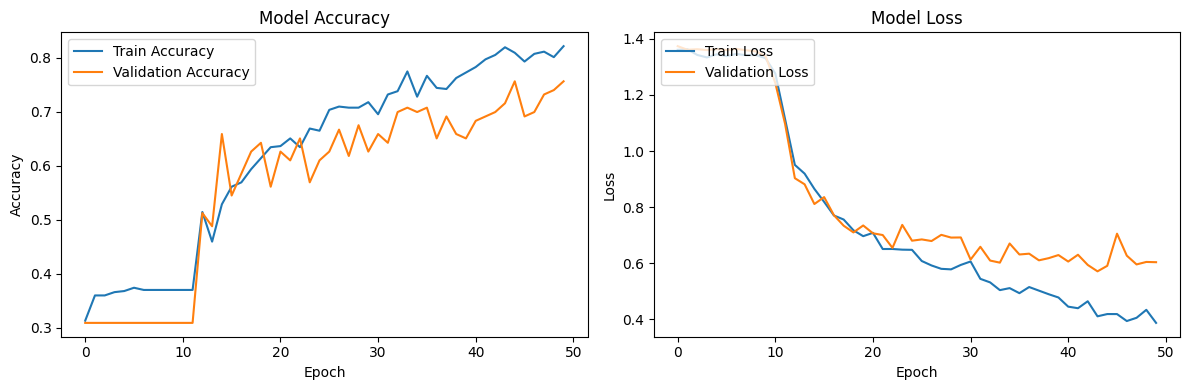

In [ ]:
import os
import numpy as np
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Class map based on subdirectory names
class_map = {
    'pure': 0,
    'medium_concentration': 1,
    'low_concentration': 2,
    'high_concentration': 3
}

# Function to load images and assign labels based on folder names
def load_images_from_subdirectories(main_directory, target_size=(128, 64, 3)):
    image_data_list = []
    label_list = []

    for subdir in os.listdir(main_directory):
        subdir_path = os.path.join(main_directory, subdir)

        if os.path.isdir(subdir_path) and subdir in class_map:
            for filename in os.listdir(subdir_path):
                if filename.endswith('.tiff'):
                    img_path = os.path.join(subdir_path, filename)
                    image = io.imread(img_path)

                    # Resize the spatial dimensions to target size (128 spectral bands, 64x3 spatial dimensions)
                    image_resized = resize(image, (target_size[0], target_size[1], target_size[2]), anti_aliasing=True)

                    image_data_list.append(image_resized)
                    label_list.append(class_map[subdir])

    if len(image_data_list) == 0 or len(label_list) == 0:
        raise ValueError("No images or labels found. Please check the directory structure and filenames.")

    return np.array(image_data_list), np.array(label_list)

# Preprocessing
images_directory = "/content/drive/MyDrive/dataset/okra/okraimages"
X_data, y_data = load_images_from_subdirectories(images_directory)

# Normalize the images
X_data = X_data / 255.0

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_data_onehot = one_hot_encoder.fit_transform(y_data.reshape(-1, 1))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data_onehot, test_size=0.2, random_state=42)

# Debug: Check shapes
print(f"X_train shape: {X_train.shape}")  # Should be (samples, 128, 64, 3)
print(f"y_train shape: {y_train.shape}")  # Should be (samples, 4)
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape for 3D CNN: (samples, depth, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], 128, 64, 1, 3)  # 128 spectral bands, 64 height, 1 width (or depth if you consider 1 band)
X_test = X_test.reshape(X_test.shape[0], 128, 64, 1, 3)  # Reshaping to match 3D CNN input

# Building the 3D CNN model
model = models.Sequential()

# 3D Convolutional layers
model.add(layers.Conv3D(32, (3, 3, 1), activation='relu', input_shape=(128, 64, 1, 3)))  # Input shape (depth, height, width, channels)
model.add(layers.MaxPooling3D((2, 2, 1)))

model.add(layers.Conv3D(64, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))

model.add(layers.Conv3D(128, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))

# Flatten the output before feeding into the dense layers
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(4, activation='softmax'))  # 4 classes

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Example: Let's say you have SMUV signatures in a NumPy array `smuv_signatures`
# `smuv_signatures` should be of shape (num_samples, num_features)
num_samples = 175  # Number of samples
num_features = 300  # Length of SMUV signature vector for each sample

# Create dummy data for illustration
smuv_signatures = np.random.rand(num_samples, num_features)

# Reshape the SMUV signatures for 1D CNN input
# The desired shape is (num_samples, num_features, 1)
X = smuv_signatures.reshape(num_samples, num_features, 1)

# Check the new shape
print(X.shape)  # Should output (100, 200, 1)

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Example: Let's say you have SMUV signatures in a NumPy array `smuv_signatures`
# `smuv_signatures` should be of shape (num_samples, num_features)
num_samples = 175  # Number of samples
num_features = 300  # Length of SMUV signature vector for each sample
num_classes = 4    # Number of classes

# Create dummy SMUV signatures data for illustration
smuv_signatures = np.random.rand(num_samples, num_features)

# Reshape the SMUV signatures for 1D CNN input
# The desired shape is (num_samples, num_features, 1)
X = smuv_signatures.reshape(num_samples, num_features, 1)

# Create dummy labels for illustration
# Here, we randomly assign each sample to one of the four classes
labels = np.random.randint(0, num_classes, num_samples)

# One-hot encode the labels for multi-class classification
y = to_categorical(labels, num_classes=num_classes)

# Check the new shape
print("Shape of X:", X.shape)  # Should output (num_samples, num_features, 1)
print("Shape of y:", y.shape)  # Should output (num_samples, num_classes)



Shape of X: (175, 300, 1)
Shape of y: (175, 4)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 661ms/step


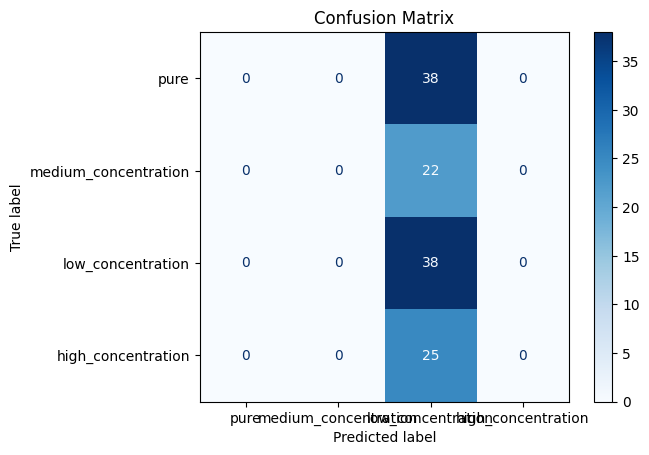

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get the predicted labels from the model
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_map.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
import kerastuner as kt

def build_model(hp):
    model = models.Sequential()

    # Conv Layers
    model.add(layers.Conv2D(hp.Int('conv1_units', 32, 128, step=32), (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp.Int('conv2_units', 32, 128, step=32), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(hp.Int('conv3_units', 64, 256, step=64), (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes

    # Compile Model
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning using Keras Tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='hyperband_dir',
                     project_name='okra_tuning')

# Search for the best parameters
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 30 Complete [00h 05m 55s]
val_accuracy: 0.5609756112098694

Best val_accuracy So Far: 0.6829268336296082
Total elapsed time: 00h 35m 52s


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get the predicted labels from the model
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions and true labels back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the classification report (precision, recall, f1-score)
class_labels = list(class_map.keys())
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)

# Print the classification report
print("Classification Report:")
print(report)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
  2/123 ━━━━━━━━━━━━━━━━━━━━ 29:13 14s/step - accuracy: 0.1875 - loss: 1.6345

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.3214 - loss: 2.3630 - val_accuracy: 0.4553 - val_loss: 1.0658
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.4306 - loss: 2.2579 - val_accuracy: 0.5041 - val_loss: 1.1005
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4412 - loss: 1.9082 - val_accuracy: 0.5447 - val_loss: 0.7998
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.4752 - loss: 1.7245 - val_accuracy: 0.5203 - val_loss: 0.8477
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5230 - loss: 1.3379 - val_accuracy: 0.5691 - val_loss: 0.8020
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5247 - loss: 1.1856 - val_accuracy: 0.4878 - val_loss: 0.8267
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.4901 - loss: 1.2792 - val_accuracy: 0.5041 - val_loss: 0.7899
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5434 - loss: 0.9701 - val_accuracy: 0.6179 - v

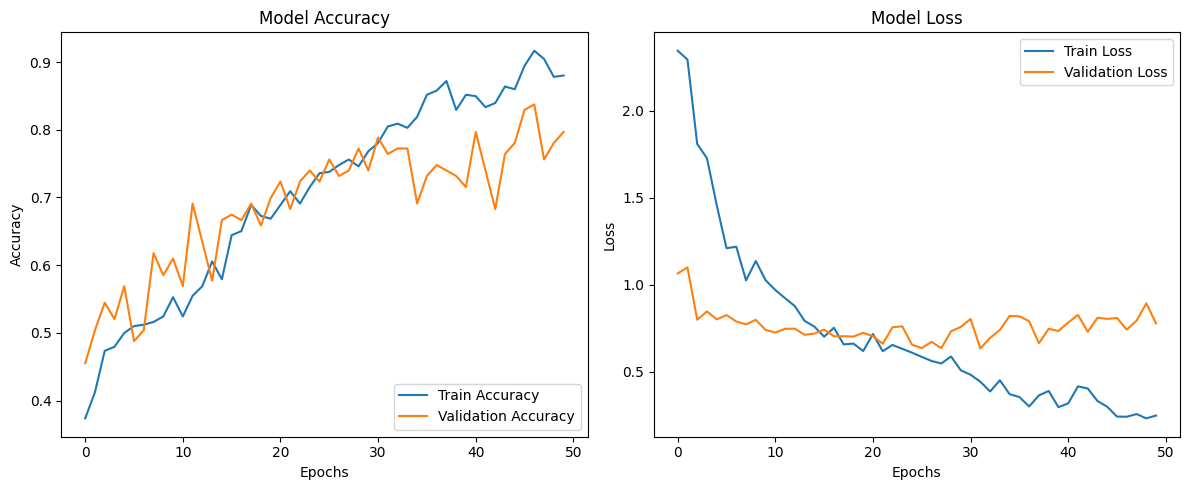

In [ ]:
import os
import numpy as np
from skimage import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Class map based on subdirectory names
class_map = {
    'pure': 0,
    'medium_concentration': 1,
    'low_concentration': 2,
    'high_concentration': 3
}

# Function to load images and assign labels based on folder names
def load_images_from_subdirectories(main_directory, target_size=(64, 64)):
    image_data_list = []
    label_list = []

    for subdir in os.listdir(main_directory):
        subdir_path = os.path.join(main_directory, subdir)

        if os.path.isdir(subdir_path) and subdir in class_map:
            for filename in os.listdir(subdir_path):
                if filename.endswith('.tiff'):
                    img_path = os.path.join(subdir_path, filename)
                    image = io.imread(img_path)
                    image_resized = np.resize(image, target_size)  # Resize image to target size
                    image_data_list.append(image_resized.flatten())  # Flatten image for NN
                    label_list.append(class_map[subdir])

    if len(image_data_list) == 0 or len(label_list) == 0:
        raise ValueError("No images or labels found. Please check the directory structure and filenames.")

    return np.array(image_data_list), np.array(label_list)

# Preprocessing
images_directory = "/content/drive/MyDrive/dataset/okra/okraimages"
X_data, y_data = load_images_from_subdirectories(images_directory)

# Normalize the images (Neural Network typically performs better with scaled data)
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

# One-hot encode the labels
y_data = to_categorical(y_data, num_classes=len(class_map))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Build the Neural Network Model
model = Sequential()

# Input layer
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.4))

# Hidden layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(len(class_map), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Test accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
class_labels = list(class_map.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Plotting the accuracy and loss graphs
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()